In [63]:
import math, warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.metrics import r2_score

In [64]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [65]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [66]:
def remove_outliers(df: pd.DataFrame, n: int, cols: list[str]) -> pd.DataFrame:
    selected_cols = [col for col in cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
    means = df[selected_cols].mean()
    stds = df[selected_cols].std()
    within_std = ((df[selected_cols] - means).abs() <= n * stds).all(axis=1)
    return df.loc[within_std].copy()

df = remove_outliers(df, 5, cols=["bid_price1","ask_price1","bid_price2","ask_price2","bid_size1","ask_size1","bid_size2","ask_size2"])

In [67]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)

    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
        .transform(lambda x: np.sqrt(
            ((x.shift(1) ** 2)
                .rolling(30, min_periods=1)
                .sum()
            ).clip(lower=0)
        ))
    )

    # TARGET
    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-30)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna()   
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [68]:
df = make_features(df)

---

In [69]:
def add_time_features(df_enriched: pd.DataFrame, period: int = 600):

    theta = 2 * np.pi * df_enriched['seconds_in_bucket'] / period
    df_enriched['sec_sin'] = np.sin(theta)
    df_enriched['sec_cos'] = np.cos(theta)
    
    return df_enriched

df = add_time_features(df)

In [70]:
df = df.sort_values(["time_id", "seconds_in_bucket"])
df.drop(columns=["bid_price1","ask_price1","bid_price2","ask_price2","mid_price","stock_id"], inplace=True)

In [71]:
def transform_and_scale(
    df_out: pd.DataFrame,
    columns: list[str],
    method: str = "auto",
    boxcox_lmbda: dict[str, float] | None = None,
    skew_threshold: float = 1.0
) -> tuple[pd.DataFrame, StandardScaler, dict[str, float]]:

    transformed = []
    lambdas = {} if boxcox_lmbda is None else boxcox_lmbda.copy()

    for col in columns:
        x = df_out[col].astype(float).to_numpy()
        min_val = x.min()
        if min_val <= 0:
            x = x - min_val + 1e-6

        use_boxcox = False
        if method == "boxcox":
            use_boxcox = True
        elif method == "log1p":
            use_boxcox = False
        else:  # auto
            skew = st.skew(x, nan_policy="omit")
            use_boxcox = abs(skew) > skew_threshold

        if use_boxcox:
            if col not in lambdas:
                lam, _ = st.boxcox(x)
                lambdas[col] = lam
            else:
                lam = lambdas[col]
            xt = st.boxcox(x, lmbda=lam)
        else:
            xt = np.log1p(x)

        transformed.append(xt.reshape(-1, 1))
        df_out[col + "_ts"] = xt  

    X = np.hstack(transformed)
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    for i, col in enumerate(columns):
        df_out[col + "_ts"] = X_scaled[:, i]

    return df_out, scaler, lambdas

In [72]:
# df, scalerSNS, lambdasSNS = transform_and_scale(df, columns=["spread","normalized_spread"],
#     method="auto",
#     skew_threshold=1.0)
# df.drop(columns=["spread","normalized_spread"], inplace=True)

In [73]:
def log1p_and_clip(
    df_out: pd.DataFrame,
    columns: list[str],
    clip_quantile: float = 0.999
) -> tuple[pd.DataFrame, dict[str, float]]:
    
    clip_thresholds: dict[str, float] = {}

    for col in columns:
        if col not in df_out:
            raise KeyError(f"Column '{col}' not found in DataFrame.")
        df_out[col] = np.log1p(df_out[col].astype(float))

        thresh = df_out[col].quantile(clip_quantile)
        clip_thresholds[col] = thresh

        df_out[col] = df_out[col].clip(upper=thresh)

    return df_out, clip_thresholds

# df, LCClips = log1p_and_clip(df, columns=['bid_size1', 'ask_size1', 'bid_size2', 'ask_size2'])

In [74]:
def zscore_skewed(
    df_out: pd.DataFrame,
    columns: list[str] | None = None,
    skew_threshold: float = 0.0
) -> tuple[pd.DataFrame, dict[str, dict[str, float]]]:

    params: dict[str, dict[str, float]] = {}

    if columns is None:
        num_cols = df_out.select_dtypes(include=np.number).columns
        to_transform = [c for c in num_cols if df_out[c].skew() > skew_threshold]
    else:
        to_transform = columns

    for c in to_transform:
        y = df_out[c].mean()
        x = df_out[c].std(ddof=0)
        params[c] = {'mean': y, 'std': x}
        df_out[c + '_z'] = (df_out[c] - y) / x

    return df_out, params

# df, z_params = zscore_skewed(df, columns=["LOB_entropy","rolling_imbalance_mean_30"])

---

In [75]:
feats = [
    c for c in df.columns
    if c not in {"stock_id", "time_id", "rv_future"}
]

In [76]:
X = df[feats].values.astype(np.float32)
y = df["rv_future"].values.astype(np.float32)

In [77]:
time_ids = df["time_id"].values
blocks = np.unique(time_ids)
block_idx = {b: i for i, b in enumerate(blocks)}
block_indices = np.array([block_idx[t] for t in time_ids])

In [78]:
n_test_blocks = max(int(0.1 * len(blocks)), 1)
block_cv = TimeSeriesSplit(n_splits=5, test_size=n_test_blocks, gap=1)

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_rmse = float("inf")
best_state = None
best_scaler = None

In [80]:
class ANN_ARCH(nn.Module):
    def __init__(self, n_in: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

In [81]:
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(np.log(np.clip(y, a_min=1e-8, a_max=None))).float()

In [82]:
for fold, (train_block_idxs, val_block_idxs) in enumerate(block_cv.split(blocks), 1):
    train_mask = np.isin(block_indices, train_block_idxs)
    val_mask   = np.isin(block_indices, val_block_idxs)
    train_idx = np.where(train_mask)[0]
    val_idx   = np.where(val_mask)[0]

    scaler = StandardScaler().fit(X[train_idx])
    X_train = scaler.transform(X[train_idx])
    X_val   = scaler.transform(X[val_idx])

    X_train_t = torch.from_numpy(X_train).to(device)
    y_train_t = y_tensor[train_idx].to(device)
    X_val_t   = torch.from_numpy(X_val).to(device)
    y_val_t   = y_tensor[val_idx].to(device)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t,   y_val_t)
    train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False)

    model = ANN_ARCH(n_in=X.shape[1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(50):
        model.train()
        for xb, yb in train_loader:
            opt.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            if not torch.isnan(loss):
                loss.backward()
                opt.step()

    model.eval()
    with torch.no_grad():
        preds = torch.cat([model(xb).cpu() for xb, _ in val_loader]).squeeze()
    rmse = torch.sqrt(((preds - y_val_t.cpu()) ** 2).mean())

    print(f"Fold {fold}: val RMSE (log-σ) = {rmse:.4f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_state = model.state_dict()
        best_scaler = scaler

Fold 1: val RMSE (log-σ) = 0.6346
Fold 2: val RMSE (log-σ) = 0.6133
Fold 3: val RMSE (log-σ) = 0.6690
Fold 4: val RMSE (log-σ) = 0.7099
Fold 5: val RMSE (log-σ) = 0.6533


In [83]:
scaler_full = StandardScaler().fit(X)
X_full = scaler_full.transform(X)
X_full_t = torch.from_numpy(X_full).to(device)
y_full_t = y_tensor.to(device)

full_ds = TensorDataset(X_full_t, y_full_t)
full_loader = DataLoader(full_ds, batch_size=1024, shuffle=True)

final_model = ANN_ARCH(n_in=X.shape[1]).to(device)
final_model.load_state_dict(best_state)
opt = torch.optim.Adam(final_model.parameters(), lr=1e-3)

In [84]:
final_model.train()
for epoch in range(50):
    for xb, yb in full_loader:
        opt.zero_grad()
        preds = final_model(xb).squeeze()
        loss = loss_fn(preds, yb)
        if not torch.isnan(loss):
            loss.backward()
            opt.step()

print(f"Best validation RMSE (log-σ) across folds = {best_rmse:.4f}")

Best validation RMSE (log-σ) across folds = 0.6133


In [85]:
final_model.eval()
with torch.no_grad():
    x_last = torch.from_numpy(
        scaler_full.transform(X[-1:].astype(np.float32))
    ).to(device)
    log_sigma = final_model(x_last).item()
    sigma = np.exp(log_sigma)  # final output

print(f"Forecast σ (future volatility) = {sigma:.9f}")

Forecast σ (future volatility) = 0.000372324


In [86]:
test_blocks = max(int(0.05 * len(X)), 1)
X_test  = best_scaler.transform(X[-test_blocks:])
y_test  = y[-test_blocks:]
log_y_test = np.log(np.clip(y_test, a_min=1e-8, a_max=None))

with torch.no_grad():
    X_tensor = torch.tensor(X_test).to(device)
    log_pred = final_model(X_tensor).cpu().numpy().ravel()

y_pred_sigma  = np.exp(log_pred)
y_true_sigma  = np.exp(log_y_test)

In [87]:
r2 = r2_score(y_true_sigma, y_pred_sigma)
print(f"R² score (σ prediction) = {r2:.6f}")

R² score (σ prediction) = 0.478604


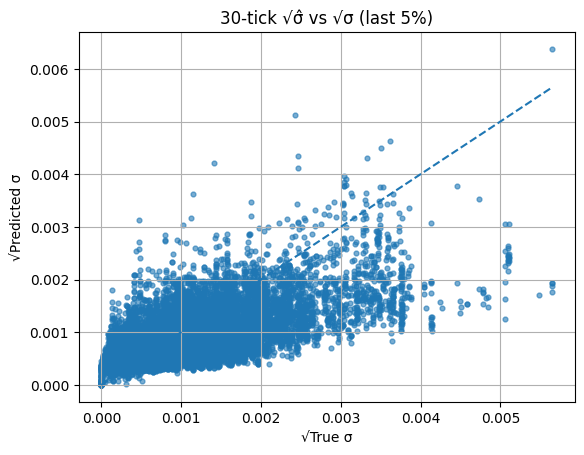

In [88]:
plt.figure()
plt.scatter(
    y_true_sigma,
    y_pred_sigma,
    s=12,
    alpha=0.6,
)
lims = [0, np.max(y_true_sigma)]
plt.plot(lims, lims, linestyle="--")
plt.title("30-tick √σ̂ vs √σ (last 5%)")
plt.xlabel("√True σ")
plt.ylabel("√Predicted σ")
plt.grid()
plt.show()

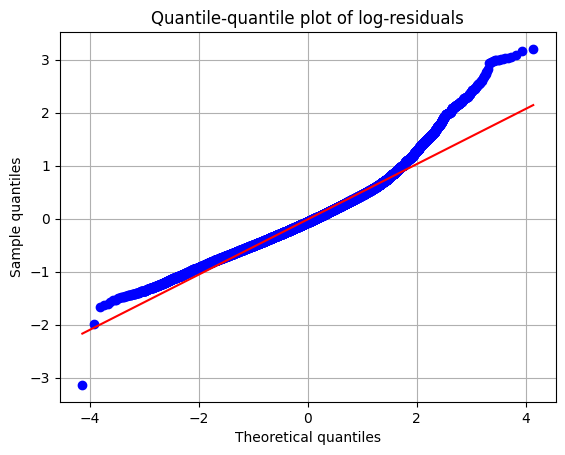

In [89]:
resid = np.log(y_pred_sigma) - np.log(y_test)
resid = resid[np.isfinite(resid)]

plt.figure()
st.probplot(resid, dist="norm", plot=plt)
plt.title("Quantile-quantile plot of log-residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.grid(True)
plt.show()